# Success Rate Over Time


The notebook will connect to the Mongo database, read all the calls made which were either a succes or a failure.

Analyse the success rate over time.

Outputs the following:

- `output_folder/SuccessRateOverTimeDf.csv` file used for the plots with headers: `date, scenario_type, success_rate`
- Time series plot (All scenarios) [SuccessRateOverTime.png](./output_folder/SuccessRateOverTime.png) 
- Time series plot (All scenarios) [SuccessRateOverTime.svg](./output_folder/SuccessRateOverTime.svg) 
- Time series plot (High success rate) [SuccessRateOverTimeHigh.png](./output_folder/SuccessRateOverTimeHigh.png) 
- Time series plot (High success rate) [SuccessRateOverTimeHigh.svg](./output_folder/SuccessRateOverTimeHigh.svg) 
- Time series plot (High success rate) part 1 [SuccessRateOverTimeHigh.png](./output_folder/SuccessRateOverTimeHighPart1.png) 
- Time series plot (High success rate) part 1 [SuccessRateOverTimeHigh.svg](./output_folder/SuccessRateOverTimeHighPart1.svg) 
- Time series plot (High success rate) part 2 [SuccessRateOverTimeHigh.png](./output_folder/SuccessRateOverTimeHighPart2.png) 
- Time series plot (High success rate) part 2 [SuccessRateOverTimeHigh.svg](./output_folder/SuccessRateOverTimeHighPart2.svg) 
- Time series plot (Low success rate) [SuccessRateOverTimeLow.png](./output_folder/SuccessRateOverTimeLow.png) 
- Time series plot (Low success rate) [SuccessRateOverTimeLow.svg](./output_folder/SuccessRateOverTimeLow.svg) 
- Time series plot (Scenarios 1, 8, 9, 10 and 11) [SuccessRateOverTimeCloseUp.png](./output_folder/SuccessRateOverTimeCloseUp.png)
- Time series plot (Scenarios 1, 8, 9, 10 and 11) [SuccessRateOverTimeCloseUp.svg](./output_folder/SuccessRateOverTimeCloseUp.svg)

In [1]:
from dotenv import load_dotenv
from pymongo import MongoClient
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import os
import json
import helperFunctions as hf

hf.setup()

In [2]:
fileOutput = "output_folder/CallsData.csv"

client = MongoClient(hf.getConnectionString())
database=client["observertc-reports"]
calls=database["calls"]


In [3]:
# Read all calls from MongoDB to data frame
df = pd.DataFrame(list(calls .find({"scenario_type": {"$exists": "true", "$ne": "scenario_type"}, "logging_type": {"$in": ["COMMAND_SESSION_SUCCESS", "COMMAND_SESSION_FAILED"]}})))

df.head(10)

,_id,timestamp,logging_type,client_type,test_id,room_id,scenario_type
0,63a5eeaf7d9c7a34f0fc241a,2022-12-23 18:08:47.460907,COMMAND_SESSION_SUCCESS,CnC,9c59f89a-c0cb-4456-8970-3e87c0baa880,68b80e67-290b-4274-a1c0-033a3ffa11aa,1
1,63a5efb87d9c7a34f0fc2420,2022-12-23 18:13:12.218286,COMMAND_SESSION_SUCCESS,CnC,9c59f89a-c0cb-4456-8970-3e87c0baa880,b5ed05d5-d541-4ff8-829d-f5f81e74722d,2
2,63a5f0277d9c7a34f0fc2426,2022-12-23 18:15:03.016289,COMMAND_SESSION_SUCCESS,CnC,9c59f89a-c0cb-4456-8970-3e87c0baa880,8b1cb51b-7422-4e49-ba05-f1bad0a3d1d1,3
3,63a5f09a7d9c7a34f0fc242c,2022-12-23 18:16:58.983577,COMMAND_SESSION_SUCCESS,CnC,9c59f89a-c0cb-4456-8970-3e87c0baa880,f9d3d518-1a54-409e-8bfd-2bb88258af0e,4
4,63a5f10b7d9c7a34f0fc2432,2022-12-23 18:18:51.007475,COMMAND_SESSION_SUCCESS,CnC,9c59f89a-c0cb-4456-8970-3e87c0baa880,301c06df-b82c-49cc-9815-328ad548b0a1,5
5,63a5f1717d9c7a34f0fc2438,2022-12-23 18:20:33.145231,COMMAND_SESSION_SUCCESS,CnC,9c59f89a-c0cb-4456-8970-3e87c0baa880,cf7879e5-3c5d-4347-8271-8c19fe57dbc6,6
6,63a5f1dc7d9c7a34f0fc243e,2022-12-23 18:22:20.156555,COMMAND_SESSION_SUCCESS,CnC,9c59f89a-c0cb-4456-8970-3e87c0baa880,2fdd8041-edcb-4f53-8b4e-d0a682cd8b4b,7
7,63a5f2567d9c7a34f0fc2444,2022-12-23 18:24:22.584733,COMMAND_SESSION_SUCCESS,CnC,9c59f89a-c0cb-4456-8970-3e87c0baa880,c310a592-6ad1-4894-8736-30444c49ea51,8
8,63a5f2b97d9c7a34f0fc244a,2022-12-23 18:26:01.976737,COMMAND_SESSION_SUCCESS,CnC,9c59f89a-c0cb-4456-8970-3e87c0baa880,2c90c2a3-f06e-4e59-b288-be02a227126b,9
9,63a5f3fa7d9c7a34f0fc2456,2022-12-23 18:31:22.548220,COMMAND_SESSION_FAILED,CnC,9c59f89a-c0cb-4456-8970-3e87c0baa880,51944215-000f-4ac4-84c8-1369641b5737,11


In [4]:
# describe the data frame
print(f"The data frame has {df.shape[0]} rows and {df.shape[1]} columns")


The data frame has 23355 rows and 7 columns


In [5]:
# For all the days in the timestamp and for each senario type, find the success rate and add to the plotData dataframe

# Find all the first and last day of the data frame
from datetime import timedelta


df['timestamp'] = pd.to_datetime(df['timestamp']) 

firstDay = df['timestamp'].min()
lastDay = df['timestamp'].max()

print(f"The first day is {firstDay} and the last day is {lastDay} range will be {(lastDay-firstDay).days + 1}")
 
# Create a new data frame with the columns we need.
plotData = pd.DataFrame(columns=['date', 'scenario_type', 'success_rate'])


for day in range((lastDay-firstDay).days + 1):
    thisDay = (firstDay + timedelta(days=day)).replace(hour=0, minute=0, second=0, microsecond=0)
    nextDay = thisDay + timedelta(days=1)
    
    print(f"Date range {thisDay.day} -> {nextDay.day}")
    # For all scenario_types, find the success rate for the day
    mask = (df['timestamp'] > thisDay) & (df['timestamp'] <= nextDay)
    dayData = df.loc[mask]

    # for all the scenario_type
    for scenario_type in dayData['scenario_type'].unique():
        # Find all the rows for the day
        scenarioData = dayData.loc[dayData['scenario_type'] == scenario_type]
        # Find the success rate for the day
        succes = len(scenarioData.loc[scenarioData['logging_type'] == "COMMAND_SESSION_SUCCESS"])
        failed = len(scenarioData.loc[scenarioData['logging_type'] == "COMMAND_SESSION_FAILED"])
        total = succes + failed

        if total > 0:
            successRate = succes/total * 100
        else:
            # TODO: Decide what to do if there is no data for the day
            raise(Exception(f"No succes or failed for scenario type {scenario_type} on day {thisDay}"))
        #print(f"On day {thisDay} does scenario type {scenario_type} has {succes} success and {failed} failed with success rate {successRate}")
        # Add the data to the plotData dataframe
        point = pd.DataFrame({'date': [thisDay], 'scenario_type': [scenario_type], 'success_rate': [successRate]})
        # Convert the date to a timestamp 
        #point['date'] = pd.to_datetime(point['date'])
        plotData = pd.concat([plotData, point], ignore_index=True, sort=False)

plotData.to_csv("output_folder/SuccessRateOverTimeDf.csv", index=False)

The first day is 2022-12-23 18:08:47.460907 and the last day is 2023-01-24 12:19:39.467538 range will be 32
Date range 23 -> 24
Date range 24 -> 25
Date range 25 -> 26
Date range 26 -> 27
Date range 27 -> 28
Date range 28 -> 29
Date range 29 -> 30
Date range 30 -> 31
Date range 31 -> 1
Date range 1 -> 2
Date range 2 -> 3
Date range 3 -> 4
Date range 4 -> 5
Date range 5 -> 6
Date range 6 -> 7
Date range 7 -> 8
Date range 8 -> 9
Date range 9 -> 10
Date range 10 -> 11
Date range 11 -> 12
Date range 12 -> 13
Date range 13 -> 14
Date range 14 -> 15
Date range 15 -> 16
Date range 16 -> 17
Date range 17 -> 18
Date range 18 -> 19
Date range 19 -> 20
Date range 20 -> 21
Date range 21 -> 22
Date range 22 -> 23
Date range 23 -> 24


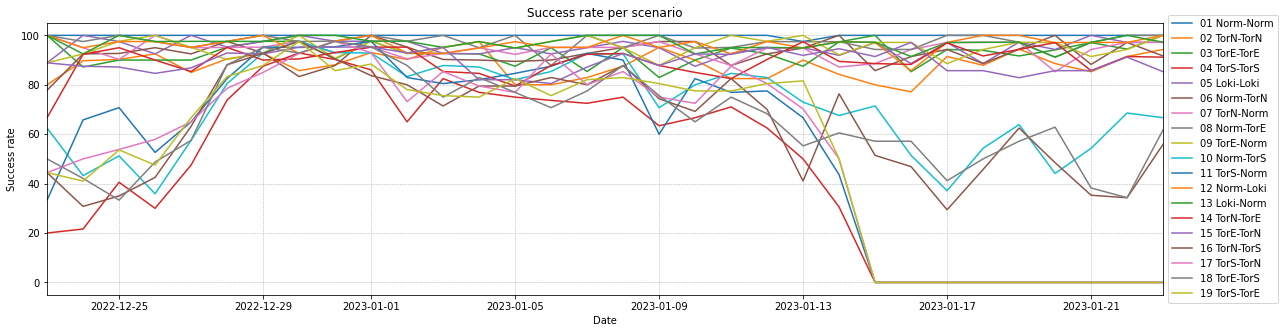

In [12]:
plt.rcParams["figure.figsize"] = (20,5)

for scenario in hf.scenarios:
    mask = plotData['scenario_type'] == str(scenario["scenario"])
    plt.plot(plotData.loc[mask]['date'], plotData.loc[mask]['success_rate'], label=hf.getScenarioLabels([scenario["scenario"]])[0])

plt.xlabel("Date")
plt.ylabel("Success rate")

plt.title("Success rate per scenario")
# set size of plot
# set grid on x-axis in plot
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5)

plt.xlim([datetime.date(2022, 12, 23), datetime.date(2023, 1, 23)])

plt.legend(fontsize=10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("output_folder/SuccessRateOverTime.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/SuccessRateOverTime.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

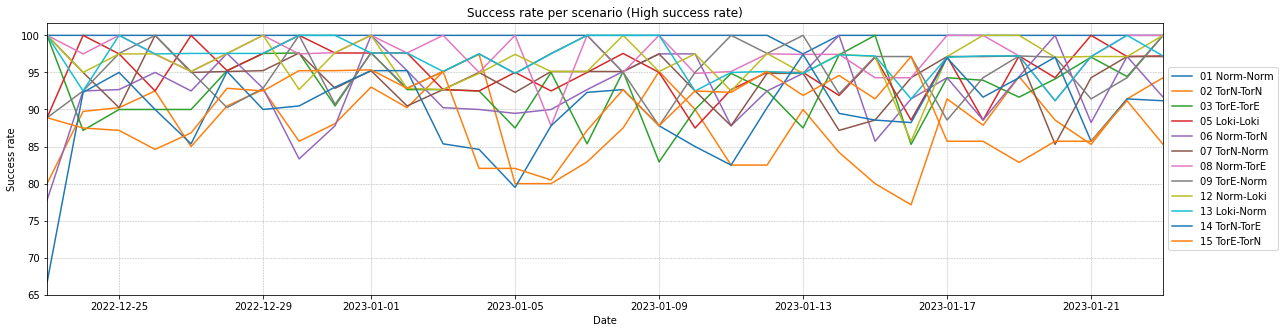

In [7]:
# All high performing scenario types
plt.rcParams["figure.figsize"] = (20,5)

for scenario in [1, 2, 3, 5, 6, 7, 8, 9, 12, 13, 14, 15]:
    mask = plotData['scenario_type'] == str(scenario)
    plt.plot(plotData.loc[mask]['date'], plotData.loc[mask]['success_rate'], label=hf.getScenarioLabels([scenario])[0])

plt.xlabel("Date")
plt.ylabel("Success rate")

plt.title("Success rate per scenario (High success rate)")
# set size of plot
# set grid on x-axis in plot
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5)

plt.xlim([datetime.date(2022, 12, 23), datetime.date(2023, 1, 23)])

plt.legend(fontsize=10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("output_folder/SuccessRateOverTimeHigh.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/SuccessRateOverTimeHigh.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

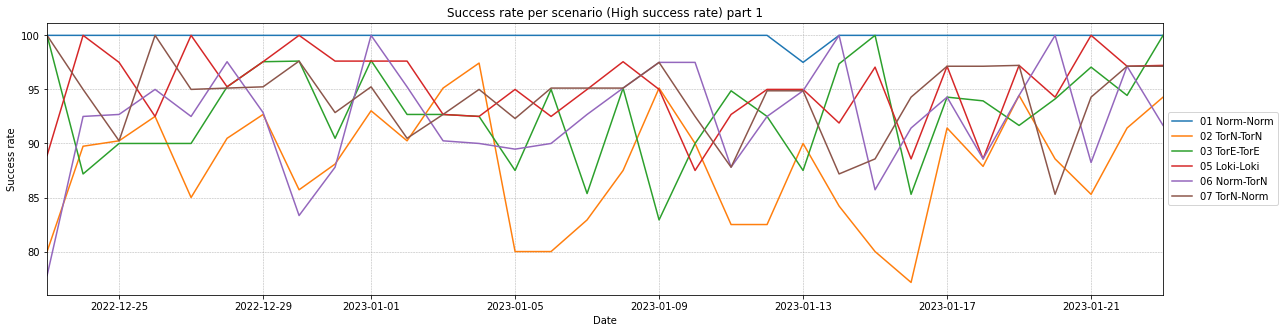

In [8]:
# All high performing scenario types
plt.rcParams["figure.figsize"] = (20,5)

for scenario in [1, 2, 3, 5, 6, 7]:
    mask = plotData['scenario_type'] == str(scenario)
    plt.plot(plotData.loc[mask]['date'], plotData.loc[mask]['success_rate'], label=hf.getScenarioLabels([scenario])[0])

plt.xlabel("Date")
plt.ylabel("Success rate")

plt.title("Success rate per scenario (High success rate) part 1")
# set size of plot
# set grid on x-axis in plot
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5)

plt.xlim([datetime.date(2022, 12, 23), datetime.date(2023, 1, 23)])

plt.legend(fontsize=10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("output_folder/SuccessRateOverTimeHighPart1.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/SuccessRateOverTimeHighPart1.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

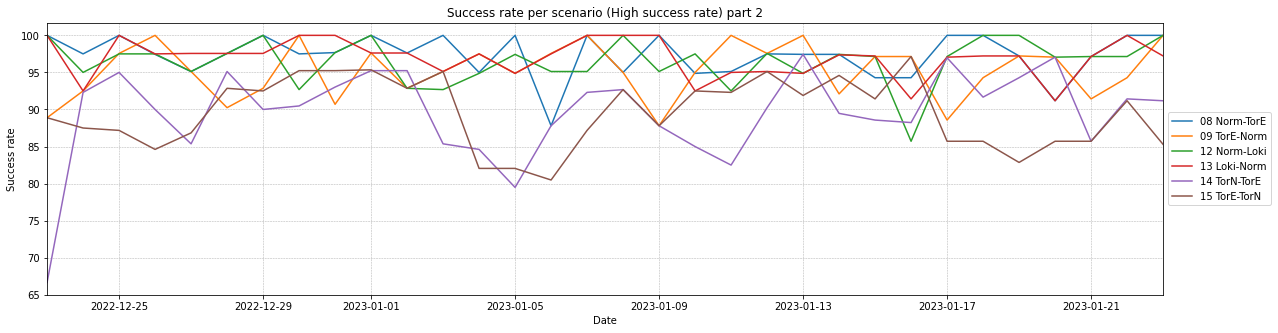

In [9]:
# All high performing scenario types
plt.rcParams["figure.figsize"] = (20,5)

for scenario in [8, 9, 12, 13, 14, 15]:
    mask = plotData['scenario_type'] == str(scenario)
    plt.plot(plotData.loc[mask]['date'], plotData.loc[mask]['success_rate'], label=hf.getScenarioLabels([scenario])[0])

plt.xlabel("Date")
plt.ylabel("Success rate")

plt.title("Success rate per scenario (High success rate) part 2")
# set size of plot
# set grid on x-axis in plot
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5)

plt.xlim([datetime.date(2022, 12, 23), datetime.date(2023, 1, 23)])

plt.legend(fontsize=10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("output_folder/SuccessRateOverTimeHighPart2.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/SuccessRateOverTimeHighPart2.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

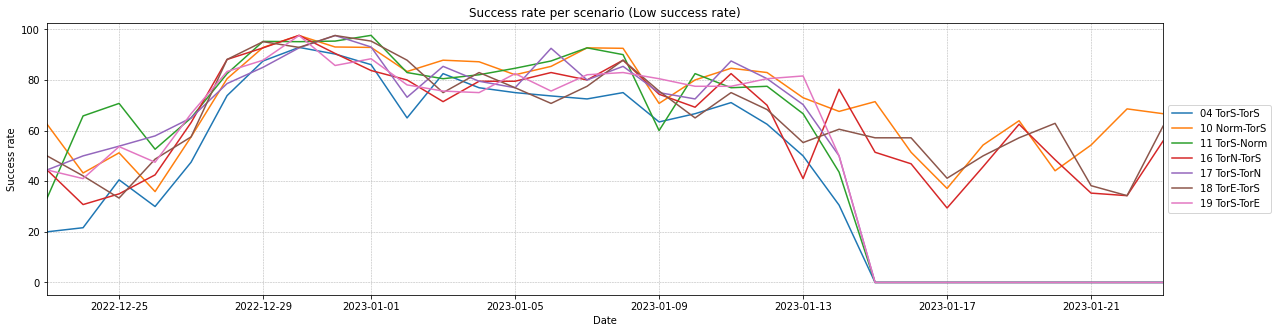

In [10]:
# All high performing scenario types
plt.rcParams["figure.figsize"] = (20,5)

for scenario in [4, 10, 11, 16, 17, 18, 19]:
    mask = plotData['scenario_type'] == str(scenario)
    plt.plot(plotData.loc[mask]['date'], plotData.loc[mask]['success_rate'], label=hf.getScenarioLabels([scenario])[0])

plt.xlabel("Date")
plt.ylabel("Success rate")

plt.title("Success rate per scenario (Low success rate)")
# set size of plot
# set grid on x-axis in plot
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5)

plt.xlim([datetime.date(2022, 12, 23), datetime.date(2023, 1, 23)])

plt.legend(fontsize=10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("output_folder/SuccessRateOverTimeLow.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/SuccessRateOverTimeLow.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()

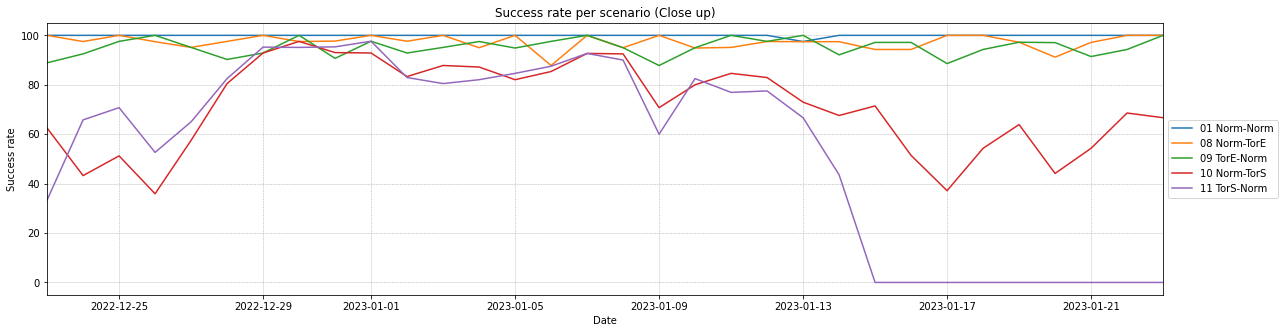

In [11]:
# All high performing scenario types
plt.rcParams["figure.figsize"] = (20,5)

dataA = []
dataB = []
for i in [1,8,9,10,11]:
  s = hf.scenarios[i-1]["scenario"]
  a = hf.scenarios[i-1]["alice"]
  b = hf.scenarios[i-1]["bob"]
  mask = plotData['scenario_type'] == str(s)
  plt.plot(plotData.loc[mask]['date'], plotData.loc[mask]['success_rate'], label=hf.getScenarioLabels([s])[0])

plt.xlabel("Date")
plt.ylabel("Success rate")

plt.title("Success rate per scenario (Close up)")
# set size of plot
# set grid on x-axis in plot
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.grid(axis='x', linestyle='--', linewidth=0.5)

plt.xlim([datetime.date(2022, 12, 23), datetime.date(2023, 1, 23)])

plt.legend(fontsize=10)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.savefig("output_folder/SuccessRateOverTimeCloseUp.png", format="png", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.savefig("output_folder/SuccessRateOverTimeCloseup.svg", format="svg", bbox_inches='tight', transparent=False, dpi=600, pad_inches=0.1, facecolor='w', edgecolor='w')
plt.show()